# User review sentiment analysis

The key topic of this research is to build *natural language processing* model for sentiment analysis of the users feedback. To generalize, this experiment consists of the following steps:
 - Set the goal of the research:
   - Defining the domain for the research and preliminary problem definition;
   - Raw data collection, which is publicly available user reviews on the popular gaming platforms (like Steam, Origin e.t.c.);
   - Storing data;
   - Data visualization and description;
 - Data preprocessing:
   - Dataset cleaning:
     - Assigning specific types to the data attributes;
     - Deleting duplicates;
     - Removing missing records (NaN, Null values): substitution with default values, mean values or deleting;
   - Exploratory data analysis:
     - Usage of descriptive statistics (MEAN, SD e.t.c) for the attributes;
     - Correlational and covariational analysis, causal researches;
   - Feature engineering, which in the NLP domain is text vectorization;
   - Data split on training + testing datasets (80 / 20 ratio) and model selection + training;
   - Validaion and hyperparameter tuning;
   - Results documenting;
   
## Problem definition
 
The key goal of the developing NLP system is to classify user game review by sentimental characteristics (e.g. joy, sadness, anger e.t.c.). The solution of this problem will result in minimizing rate of unfair scores of the games on the platform and group review by the temperament. The core entity in this experiment is `review`, that contains following attributes:
 - id          *uuid* - a unique comment identifier;
 - app_id      *int* - a game id, which comment is related to;
 - nickname    *varchar* - an author of the review;
 - date_time   *timestamp* - the date of the review posting;
 - containment *varchar* - the review content, which is an input attribute;
 - reaction    *varchar* - sentimental characteristics of the review, which is **manually labeled**;
 
Input parameter is an `containment` attribute, which is a charset with max length of 10000 symbols, and output parameter is a single class of containment temperament from a set `[sadness, love, fear, surprise, joy, anger]`.
 
## Data analysis platform

All data processing is performed on the `Apache Spark` computational engine for streaming and batching processing of the Big Data using the paradigm, similar to **MAP-REDUCE**, which is a part of ecosystem of `Hadoop`. Unlike pure Python solutions (which does all processing in the instructions interpreter mode), `Apache Spark` performs effective procedure of data parallelization and fast computation using *RDD (Resilient Distributed Dataset)*.

**MAP-REDUCE** is a programming model that allows you to perform simple and efficient distribution of computational tasks on each node (core) of a computing device or cluster. The model consists of basic steps:
  - ** MAP ** - performs the procedure of distribution of each value in the dataset to create a new data structure;
  - ** REDUCE ** - performs the procedure of combining the data structure into a new value;

The input and output for each step are represented as a `key-value` pair, and the procedures themselves are specified according to the following pattern:

```
map (in_key, in_value)
    list (out_key, intermediate_value)
    
reduce (out_key, list (intermediate_value))
    list (out_value)
```

The ** MAP ** function creates an intermediate value for the intended source key, the ** REDUCE ** function combines all intermediate values for a specific key. The classic ** MAP-REDUCE ** works in synchronous mode. The input data is separated and several `map ()` tasks are performed in parallel. After all `map ()` procedures are completed, all intermediate values are combined for all unique keys, performing several `reduce ()` tasks in parallel.

###### Example of the MAP-REDUCE execution

The task of deriving unique words in the text and counting the number of their repetition:
  - **MAP**: Dividing each sentence from the dataset into a single word and assigning it a repetition index of 1;
  - **REDUCE**: Grouping word-index pairs by calculating the number of elements in each group;
  
![Documentation](../docs/map_reduce_example.png)


## Internal Apache Spark settings

`Apache Spark` can work both on a single computing device and on a set of computing devices connected in a cluster (known as a SPARK-cluster). Typically, any cluster has a resource manager that efficiently handles the load between those resources. The two most widely used resource managers are ** YARN ** and ** Mesos **. The resource manager consists of two main components:
  - Cluster manager;
  - Worker (Worker);
  
This is like a *master-slave* architecture, in which the cluster manager acts as the master node and the working node acts as the slave node in the cluster. The cluster manager keeps track of all information about workstations and their current status. Cluster managers always store the following information:
  - Status of the working node (busy / available);
  - Location of the working node;
  - Memory of the working node;
  - The total number of processor cores of the working node;

The main role of the cluster manager is to manage workstations and assign tasks to them, based on the availability and capacity of the workstation. On the other hand, the workstation is only responsible for performing the task assigned to it by the cluster manager.

The main advantages of `Apache Spark` over other solutions:
  - Simplicity;
  - ML and analytics tools;
  - Real-time streaming;
  - Increase in performance (due to the use of RAM resources in the calculation);
  
Let's check the presence of the `Apache Spark` cluster on the device

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark

Out[1]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.0 
 Master 
 local[*] 
 AppName 
 Databricks Shell

There are multiple ways to access files from `Databricks` cluster, the one that used here is mounting Azure Blob storage to the `HDFS://` with `Shared Access Signature`

In [ ]:
%scala

val containerName = "" # Container name of the storage account
val storageAccountName = "" # Storage on the Azure Blob service
val sas = ""
val config = "fs.azure.sas." + containerName+ "." + storageAccountName + ".blob.core.windows.net"

dbutils.fs.mount(
  source = "wasbs://" + containerName + "@" + storageAccountName + ".blob.core.windows.net/TrainData",
  mountPoint = "/mnt/traindata",
  extraConfigs = Map(config -> sas))

Reading data sources from mounted point

In [ ]:
%python

from pyspark.sql.functions import *
from pyspark.sql.types import *

schema = StructType() \
      .add("comment", StringType(), True)\
      .add("emotion", StringType(), True)

dataset = spark.read.format("csv")\
      .option("header", "true")\
      .option("sep", ";")\
      .schema(schema)\
      .load("/mnt/traindata")

display(dataset)

As in example above, we perform the map-reduce operation to count unique classes of our model

In [ ]:
agg_labels = dataset.select(col("emotion")).rdd.map(lambda word: (word[0], 1))\
                                            .reduceByKey(lambda x, y: x + y)\
                                            .toDF(["label", "count"])

agg_labels.toPandas()

Out[4]:

,label,count
0,sadness,5794
1,love,1641
2,fear,2373
3,surprise,719
4,joy,6761
5,anger,2709


The visualization of the count comparison. From this perspecive, the major issue with the dataset is label imbalancy, which can result underfitting of the model on most of the labels.

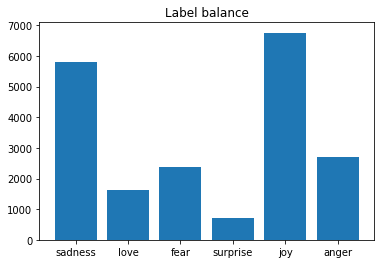

In [ ]:
import matplotlib.pyplot as plt

label_summary = agg_labels.toPandas()

plt.bar(label_summary["label"], label_summary["count"])
plt.title("Label balance")
plt.show()

Let's perform **EDA** on the classes count column. The problem from above was confirmed - labels count has major imbalance, which can be seen in a high value of the **Standart deviation**.

In [ ]:
agg_labels.select("count").summary().toPandas()

Out[9]:

,summary,count
0,count,6
1,mean,3332.8333333333335
2,stddev,2400.605791600667
3,min,719
4,25%,1641
5,50%,2373
6,75%,5794
7,max,6761


We apply the same operation on the features attribute to highlight the unique words in order to build a vocabulary for our model.

In [ ]:
split_sentence_udf = udf(lambda x: x.split(" "), ArrayType(StringType()))

agg_words = dataset.select(explode(split_sentence_udf(col("comment"))))\
                            .rdd.map(lambda word: (word[0], 1))\
                            .reduceByKey(lambda x, y: x + y)\
                            .toDF(["word", "count"])

agg_words.orderBy(col("count").desc()).toPandas()

Out[10]:

,word,count
0,i,32241
1,feel,13937
2,and,11995
3,to,11208
4,the,10462
...,...,...
17091,vaccine,1
17092,internalize,1
17093,textbook,1
17094,dams,1


Repeat the same **EDA** procedure on `word` count attribute.

In [ ]:
agg_words.select("count").summary().toPandas()

Out[11]:

,summary,count
0,count,17096
1,mean,22.38365699578849
2,stddev,346.3475707348748
3,min,1
4,25%,1
5,50%,1
6,75%,4
7,max,32241


Let's visualisate the word count distribution on the plot. It's important to remember, that one of the main problems in the **natural language processing** is the unstructured input data. For example, if you use the **raw** data and receive tokens by splitting with the **SPACE** symbol, you can get invalid tokens such as *3.5?*, *[Flip]*, etc. Before the analysis of characteristics it is necessary to carry out preliminary processing of the received words, for example:
  - Remove duplicate tokens;
  - Delete residual words (STOPWORDS);
  - Normalize words (convert all letters in the token to uppercase);

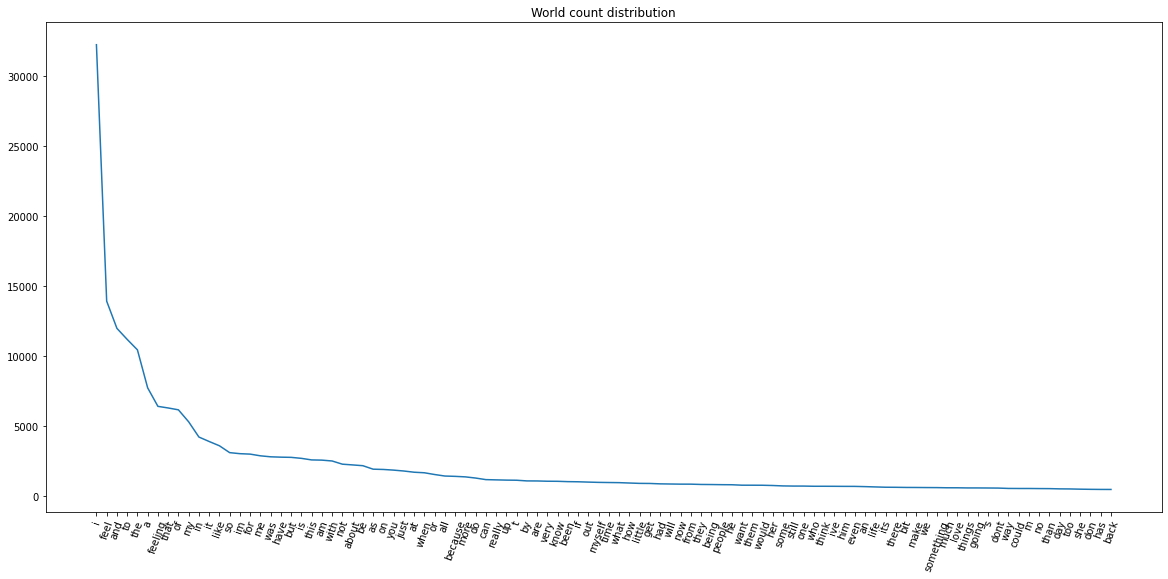

In [ ]:
import matplotlib.pyplot as plt

words_distribution = agg_words.orderBy(col("count").desc()).limit(100).toPandas()

fig, ax = plt.subplots(1, 1, figsize=(20, 9))

ax.plot(words_distribution["word"], words_distribution["count"])
ax.set_title("World count distribution")

plt.xticks(rotation=70)
plt.show()

Dataset clean the dataset by droping duplicates and records with missing fields (with values `NaN`).

In [ ]:
dataset = dataset.dropDuplicates(["comment", "emotion"])
dataset = dataset.dropna(thresh=2, subset=("comment", "emotion"))

dataset.count()

Out[17]: 19996

Now we spilt dataset on training subset for fitting the model and testing dataset to evaluate the metrics. Here is used the classical approach with splitting by `80/20` ratio.

In [ ]:
train, test = dataset.randomSplit([0.8, 0.2])

train_df, test_df = train.toPandas(), test.toPandas()

train_df

Out[18]:

,comment,emotion
0,a boyfriend with whom i split up with came ove...,anger
1,a certain friend tried to push me off a seat i...,anger
2,a father of children killed in an accident,sadness
3,a few monthe ago,anger
4,a friend of mine suggested that i become a fil...,joy
...,...,...
16048,when they phoned me from greatbritain to tell ...,joy
16049,when we rearranged furniture in our flat and g...,anger
16050,when we stayed in vienna with our class,fear
16051,when we were able to afford a new sofa a leath...,joy


The preview of the test subset

In [ ]:
test_df

Out[19]:

,comment,emotion
0,a group of youngsters dressed in fads talked f...,anger
1,a teacher was very blunt in his relation to a ...,anger
2,after my boyfriend and i had separated,sadness
3,always when i am well succeded,joy
4,at a party i met a girl who drew me to her,anger
...,...,...
3938,when my mother kept me in leadingstrings,anger
3939,when my mother was seriously ill and had to be...,fear
3940,when people harrass me i feel oppressed by the...,anger
3941,while cycling in the country,fear


To train and test models we need to convert data from dataframe type to the `Numpy` tensor respresentation. 

In [ ]:
X_train, y_train = train_df['comment'].values, train_df['emotion'].values
X_val, y_val = test_df['comment'].values, test_df['emotion'].values

## Vectorization of text

Algorithms work only with numeric data and cannot perceive the text in its original form. The main interpretation of the text is its vectorization: comparison to each token (word, letter, etc.) of the corresponding vector from the space $ X \subset \mathbb {R} \times \mathbb {R} $. The simplest (but reliable for classification problems) text vectorization algorithm is *Bag of words* representation, which is as follows:
 1) Find N of the most popular words in the training dataset and number them, so we got a dictionary for learning the model;
 2) For each token in the dictionary to compare the zero-vector of dimension $ N $;
 3) For each vector we put 1 in the position corresponding to the index of the token in the dictionary;
 
Consider an example for a dictionary with N = 4 with tokens `['hi', 'you', 'me', 'are']`. Let's build a dictionary on the first step of the algorithm `{'hi': 0, 'you': 1, 'me': 2, 'are': 3}`. Let's have the text that needs to be converted into a vector: `hi how are you`. Let's carry out vectorization by algorithm:
 1) Put the zero-vector `[0, 0, 0, 0]`;
 2) Go through each token in the text and if the token is in the dictionary, then add 1 to the index position:
 
```
'hi': [1, 0, 0, 0]
'how': [1, 0, 0, 0] # token 'how' is not in the dictionary
'are': [1, 0, 0, 1]
'you': [1, 1, 0, 1]
```

Received the following vector: `[1, 1, 0, 1]`

It is worth noting that this metric does not take into account *weight* values of tokens relative to the context (input sentence). To do this, use the vector characteristic $ tfidf (t, d, D) = tf(t, d) \cdot idf(t, D) $. *TF-IDF* is a statistical indicator used to assess the importance of words in the context of a document that is part of a collection of documents or corpus. The weight (significance) of a word is proportional to the number of uses of that word in the document, and inversely proportional to the frequency of use of the word in other documents of the collection.

The indicator *TF-IDF* is used in the tasks of text analysis and information retrieval. It can be used as one of the criteria for the relevance of the document to the search query, as well as when calculating the degree of relatedness of documents in clustering.

*TF* (term frequency - word frequency) - the ratio of the number of occurrences of the selected word to the total number of words in the document. That is, the importance of the word $ t_{i} $ within the selected document is assessed:

> $ TF = \frac{n_{i}} {\sum_{k} n_{k}} $, where $ n_{i} $ is the number of occurrences of the word in the document, and in the denominator - the total number of words

*IDF* (inverse document frequency) - inversion of the frequency with which the word occurs in the documents of the collection. Using IDF reduces the weight of commonly used words:

> $ IDF = \log \frac {| D | } {| (t_{i} \subset d_{i}) | } $, where $ | D | $ - number of collection documents, $ | (t_{i} \subset d_{i}) | $ - the number of documents in which the word $ t_{i} $ occurs (when $ n_{i} \neq 0 $)

In other words, the exponent *TF-IDF* is the product of two factors: $ TFIDF = TF \times IDF $. Words with a high frequency of occurrence within the document and a low frequency of use in other documents of the collection will receive more attention *TF-IDF*.

Also we should highlight the fact, that **BoW** model does not take into account the word positions in the sentence, for instance, model will treat some sentences as following: "I AM STUDENT!" = "AM I STUDENT?". Although these sentences are the same for the model, for us they have different meaning, and the common solution to fix this issue is to use **N-gram** method - use multiple word as a single token. Used range for this tokenization is *1-2*.

In [ ]:
from joblib import parallel_backend
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

DICT_SIZE=20000

tfidf_vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w\w+\b",
                                   analyzer='word', ngram_range=(1, 2),
                                   max_df=0.9, max_features=DICT_SIZE)

with parallel_backend('threading', n_jobs=4):
    tfidf_vectorizer.fit(train_df['comment'].append(test_df['comment']).values)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)

Summary of built vocabulary.

In [ ]:
vocab = tfidf_vectorizer.vocabulary_
reversed_vocab = {i:word for word,i in vocab.items()}

len(vocab.keys())

Out[22]: 20000

We examine the first 1000 tokens to ensure there are no redundant and meaningless ones.

In [ ]:
from IPython.display import display, Markdown, Latex

vocab_plain = "Vocaburlary: \n\n" + ", ".join(list(vocab.keys())[:1000])

display({'text/plain': vocab_plain,
         'text/markdown': vocab_plain}, raw=True)

Vocaburlary: 

boyfriend, with, whom, split, up, came, over, to, friends, house, where, was, visiting, male, friend, in, confrontation, another, room, he, tried, find, out, if, by, my, feeling, parts, with whom, up with, over to, where was, in another, he tried, tried to, to find, find out, out if, if was, by my, my friend, by feeling, feeling my, certain, push, me, off, seat, very, violent, way, for, no, apparent, reason, it, may, be, that, excited, about, something, to push, me off, in very, very violent, way for, for no, no apparent, apparent reason, it may, may be, be that, that he, he was, excited about, about something, father, of, children, killed, an, accident, of children, in an, an accident, few, ago, mine, suggested, become, film, extra, the, idea, seemed, funny, and, reaction, rather, others, friend of, of mine, the idea, to me, me and, and my, to the, the others, gigantic, climbed, face, what, is, more, own, flat, over my, my face, face and, and what, what is, is more, more in, in my, my own, girl, entered, work, greeted, everybody, but, not, in the, work and, but not, not me, relationship, which, had, put, trust, in which, which had, put my, my trust, scene, one, man, repressed, one man, another one, study, visit, chicken, factory, after, receiving, grade, on, paper, mentioned, fear, on the, mentioned in, arriving, new, zealand, as, teenager, first, overseas, trip, change, etc, in new, new zealand, about the, the change, child, suffered, even, since, than, as child, sadness, as in, at, situation, felt, myself, neglected, at certain, school, at school, some, at the, of some, some of, of my, my friends, before, exam, getting, back, results, test, getting back, back the, the results, results of, in school, being, family, having, seen, them, years, with my, my family, not having, them for, for years, subject, unfair, treatment, working, group, boy, you, have, been, admitted, medicine, your, uncle, coming, canada, next, week, told, happy, moment, you have, have been, admitted to, school and, and your, is coming, coming back, next week, my father, told me, and it, it was, was happy, climbing, mountain, see, view, to see, day, received, score, acceptance, into, chosen, course, into my, death, grandmother, death of, from, person, loved, much, very much, discovering, good, lied, good friend, friend had, lied to, during, holiday, met, again, who, commit, suicide, she, just, left, hospital, during my, my holiday, friend who, who had, to commit, she had, had just, last, academic, year, ie, closure, during the, the last, just before, before the, the closure, weekend, home, the weekend, at home, every, time, meet, dog, has, once, bitten, every time, that has, thief, fear of, finding, am, able, student, thought, finding out, out that, that am, am not, not an, ill, seriously, anatomy, lesson, loss, close, or, relative, for the, the loss, loss of, close friend, friend or, sent, company, expense, state, plan, trip to, to another, to work, work for, for week, week at, at that, going, take, driving, going to, to take, take my, offer, do, offer to, to do, hearing, west, lot, better, china, hearing about, lot better, better than, discussion, concerning, bad, burdened, our, bad person, person for, for feeling, feeling burdened, burdened by, by our, our relationship, href, http, groggy, href http, feeling groggy, absolutely, cannot, wait, september, th, roll, around, feel, calm, suppose, waiting, cannot wait, wait for, to roll, feel calm, my waiting, love, this, skinny, doing, wonders, fabulous, love this, it is, is doing, for me, and feel, feel fabulous, accomplishment, get, physically, unhappy, life, missing, right, now, working and, and the, the feeling, feeling of, of accomplishment, get from, from it, it but, but am, unhappy with, with the, the family, family life, am missing, right now, accepted, his, apology, because, like, remorseful, how, treated, because feel, feel like, like he, remorseful for, for how, how he, he treated, tr

Just like input features, output labels should be transformed into numerical format: `[sadness, love, fear, surprise, joy, anger]` $ \implies $ `[0, 1, 2, 3, 4, 5]`.

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
labels = encoder.fit(train_df['emotion'].append(test_df['emotion']).values)

Example of labels transformation.

In [ ]:
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)

y_train[:10]

Out[25]: array([0, 0, 4, 0, 2, 0, 0, 4, 0, 0])

Now features are in a form of a sparse vector with $ 1 \times N $ dimensionality, where $ N = 20000 $ - vocabulary size.

In [ ]:
display({'text/plain': str(X_train[0]),
         'text/markdown': str(X_train[0])}, raw=True)

(0, 1143)	1
 (0, 2270)	1
 (0, 2474)	2
 (0, 2482)	1
 (0, 2493)	1
 (0, 2542)	1
 (0, 3207)	1
 (0, 5691)	1
 (0, 5888)	1
 (0, 6118)	1
 (0, 6124)	1
 (0, 6418)	2
 (0, 6428)	1
 (0, 7297)	1
 (0, 7347)	1
 (0, 7843)	1
 (0, 8027)	1
 (0, 8084)	1
 (0, 8275)	2
 (0, 8282)	1
 (0, 9960)	1
 (0, 10608)	2
 (0, 10752)	1
 (0, 12179)	1
 (0, 12194)	1
 (0, 12228)	1
 (0, 12240)	1
 (0, 12336)	1
 (0, 13347)	1
 (0, 14399)	1
 (0, 16946)	2
 (0, 17105)	1
 (0, 17629)	1
 (0, 17631)	1
 (0, 17909)	1
 (0, 17956)	1
 (0, 18276)	1
 (0, 18407)	2
 (0, 19042)	1
 (0, 19065)	1
 (0, 19213)	1
 (0, 19354)	3
 (0, 19442)	1

The model includes SVM classifier ensemble with `OneVsOneClassifier` strategy on top. It consists in fitting one classifier per class pair with $ \frac{N \cdot N - 1}{2} $ classifiers in ensemble. Model structure can be described in a following diagram:

![Documentation](../docs/sentiment-model-svm.png)

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import RidgeClassifier, LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.multiclass import OneVsOneClassifier

classifier = OneVsOneClassifier(LinearSVC(max_iter=10000))

Performing training with hyperparameter tuning.

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(classifier, {'estimator__C': [0.01, 0.1, 1.0, 10.0]}, n_jobs=24)
clf.fit(X_train, y_train)

Out[30]: GridSearchCV(estimator=OneVsOneClassifier(estimator=LinearSVC(max_iter=10000)),
 n_jobs=24, param_grid={'estimator__C': [0.01, 0.1, 1.0, 10.0]})

Get the estimator with the best hyperparameter.

In [ ]:
model = clf.best_estimator_

model

Out[32]: OneVsOneClassifier(estimator=LinearSVC(max_iter=10000))

Score on the training subset.

In [ ]:
model.score(X_train, y_train)

Out[33]: 0.9980066031271413

Score on the validation subset.

In [ ]:
clf.score(X_val, y_val)

Out[34]: 0.887648998224702

Example of the class prediction.

In [ ]:
y_predicted = model.predict(X_val)

y_predicted[:10]

Out[35]: array([0, 0, 4, 2, 0, 0, 2, 2, 0, 4])

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) - for this task, computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in expected.
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) - can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) - Receiver Operating Characteristic Area Under the Curve.
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight $ \sum_{n} (R_{n} - R_{n-1})P_{n} $.

In [ ]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

pd.DataFrame([
    ['Accuracy', accuracy_score(y_val, y_predicted)],
    ['F1 Weighted', f1_score(y_val, y_predicted, average='weighted')],
    ['Precision', precision_score(y_val, y_predicted, average='weighted')],
    ['Recall', recall_score(y_val, y_predicted, average='weighted')]
], columns=['Metric', 'Value'])

Out[36]:

,Metric,Value
0,Accuracy,0.887649
1,F1 Weighted,0.887297
2,Precision,0.887366
3,Recall,0.887649


Plotting ROC curve, that shows the efficiency of the classifier. The results clearly showing, that some classes, like `[fear, love, sadness]` have bad performance: `FP` rate is much bigger than `TP` rate. This issue can be solved by gathering more user comments on the service.

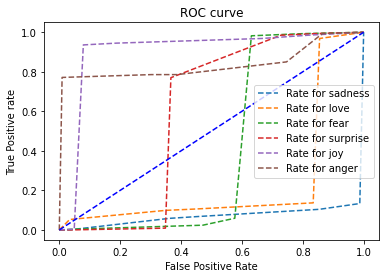

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


for i in range(len(label_summary["label"])):
    fpr, tpr, thresh = roc_curve(y_val, y_predicted, pos_label=i)
    plt.plot(fpr, tpr, linestyle='--', label=f'Rate for {label_summary["label"][i]}')

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_val))]
p_fpr, p_tpr, _ = roc_curve(y_val, random_probs, pos_label=0)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

Example of the classification.

In [ ]:
features = tfidf_vectorizer.transform(["i can not believe i spent my money on this game",
                                       "this game just makes me feel better",
                                       "yes"])
label = model.predict(features)
output = encoder.inverse_transform(label)

output

Out[45]: array(['anger', 'joy', 'joy'], dtype=object)

## Model training with data cleaning

**Pipeline of pre-processing of text data** is divided into the following stages:
  - Tokenization: division of sentences into separate tokens (in this case words);
  - Removal of stopwords (words that do not contain any meaningful information: "a", "the" e.t.c.);
  - Norvig-Sweeting model: spellchecking model from [John Snow Labs](https://nlp.johnsnowlabs.com/);
  - Lemmatization: reduction of tokens (words) to a common lemma (for example 'learning' $ \implies $ 'learn');
  - Normalization: reduction of tokens to a single case;
 
All these steps are necessary to reduce the number of words that have the same meaning, which makes the model more resistant to noise.

In [ ]:
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import Tokenizer, NorvigSweetingModel, LemmatizerModel,\
                                Normalizer, StopWordsCleaner

from pyspark.ml import Pipeline


assembler = DocumentAssembler()\
                .setInputCol("features")\
                .setOutputCol("doc")
tokenizer = Tokenizer()\
                .setInputCols(["doc"])\
                .setOutputCol("tokens_annotations")
stop_words = StopWordsCleaner()\
                .setInputCols(["tokens_annotations"])\
                .setOutputCol("clean_tokens_annotations")\
                .setCaseSensitive(False)
norvig_pretrained = NorvigSweetingModel.pretrained()\
                .setInputCols(["clean_tokens_annotations"])\
                .setOutputCol("norvig_annotations")
lemmatizer = LemmatizerModel.pretrained()\
                .setInputCols(["norvig_annotations"])\
                .setOutputCol("lemma_annotations")
normalizer = Normalizer()\
                .setInputCols(["lemma_annotations"])\
                .setOutputCol("normtoken_annotations")\
                .setLowercase(True)
finisher = Finisher()\
            .setInputCols(["normtoken_annotations"])\
            .setOutputCols(["normtokens"])\
            .setOutputAsArray(True)


sparknlp_pipeline = Pipeline().setStages([
                        assembler, tokenizer, stop_words,
                        norvig_pretrained, lemmatizer, normalizer, finisher
                    ])

tokenizer_model = sparknlp_pipeline.fit(dataset.select(col("comment").alias("features"), col("emotion")))
processed = tokenizer_model.transform(dataset.select(col("comment").alias("features"), col("emotion"))).select(col("normtokens").alias("features"), col("emotion").alias("label"))
features, label = processed.first()

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[ | ][ / ][ — ][ \ ][ | ][ / ][OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ][ / ][OK!]

In [ ]:
features, label

Out[59]: (['go',
 'feel',
 'hopeless',
 'damn',
 'hopeful',
 'around',
 'someone',
 'care',
 'awake'],
 'sadness')

Performing same operations from above

In [ ]:
join_tokens_udf = udf(lambda tokens: " ".join(tokens), StringType())
cleaned_df = processed.select(join_tokens_udf(col("features")).alias("features"), col("label"))

train, test = cleaned_df.randomSplit([0.8, 0.2])
train_df, test_df = train.toPandas(), test.toPandas()

train_df

Out[67]:

,features,label
0,aa meet today really start feel isolate everyo...,sadness
1,able feel everything exactly sweet boy birth c...,joy
2,able feel little bit emotional freedom,sadness
3,able feel pressure talk group way well year se...,fear
4,able feel pretty,joy
...,...,...
15981,yet meet cancer patient feel burden poor self ...,sadness
15982,yoga open feel tender two hour late m nicely s...,love
15983,young cant get feel back shes get killer grin ...,sadness
15984,young think move country feel accept belong,joy


In [ ]:
DICT_SIZE = 1000

df_full = cleaned_df.toPandas()

X_df_train, y_df_train = train_df['features'].values, train_df['label'].values
X_df_val, y_df_val = test_df['features'].values, test_df['label'].values

df_vectorizer = TfidfVectorizer(token_pattern=r"(?<!\d|\S)\b[a-zA-Z]{3,}\b",
                                   analyzer='word', ngram_range=(1, 1),
                                   max_df=0.9, max_features=DICT_SIZE)

with parallel_backend('threading', n_jobs=4):
    df_vectorizer.fit(df_full['features'].values)
    X_df_train = df_vectorizer.transform(X_df_train)
    X_df_val = df_vectorizer.transform(X_df_val)

In [ ]:
df_encoder = LabelEncoder().fit(df_full['label'].values)
y_df_train = df_encoder.transform(y_df_train)
y_df_val = df_encoder.transform(y_df_val)

df_labels[:10]

Out[71]: array([2, 4, 4, 5, 3, 4, 2, 2, 4, 4])

In [ ]:
cl_classifier = OneVsOneClassifier(LinearSVC(max_iter=10000))
cl_classifier.fit(X_df_train, y_df_train)

cl_classifier.score(X_df_val, y_df_val)

Out[72]: 0.8880299251870324

In [ ]:
y_df_predicted = cl_classifier.predict(X_df_val)

pd.DataFrame([
    ['Accuracy', accuracy_score(y_df_val, y_df_predicted)],
    ['F1 Weighted', f1_score(y_df_val, y_df_predicted, average='weighted')],
    ['Precision', precision_score(y_df_val, y_df_predicted, average='weighted')],
    ['Recall', recall_score(y_df_val, y_df_predicted, average='weighted')]
], columns=['Metric', 'Value'])

Out[74]:

,Metric,Value
0,Accuracy,0.888030
1,F1 Weighted,0.887266
2,Precision,0.888110
3,Recall,0.888030


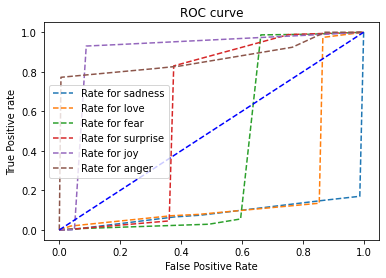

In [ ]:
for i in range(len(label_summary["label"])):
    fpr, tpr, thresh = roc_curve(y_df_val, y_df_predicted, pos_label=i)
    plt.plot(fpr, tpr, linestyle='--', label=f'Rate for {label_summary["label"][i]}')

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_val))]
p_fpr, p_tpr, _ = roc_curve(y_val, random_probs, pos_label=0)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

Saving model to the environment.

In [ ]:
import mlflow

with mlflow.start_run():
  mlflow.sklearn.log_model(tfidf_vectorizer, "original-sentimental-vectorizer")
  mlflow.sklearn.log_model(model, "original-sentimental-detector")
  mlflow.sklearn.log_model(encoder, "original-sentimental-encoder")
  mlflow.sklearn.log_model(cl_classifier, "cleared-sentimantal-detector")